In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys
sys.path.append('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code/Experiment/Evaluation')
from Evaluation import *
import jieba
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import logging
from gensim.test.utils import get_tmpfile
from sklearn.manifold import SpectralEmbedding, Isomap, MDS, TSNE
from scipy.stats import ks_2samp
from scipy.stats import zscore
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
colors={
#     'all':'#c24e3d',
    'weak':'#7b5347',
    'neutral':'#35180e',
    'strong':'#cb8d79',
}

labels={
#     'all':'全部政策',
    'weak':'weak',
    'neutral':'moderate',
    'strong':'strong',
}

data = {}

def pvalue2stars(x):
    if x<0.01:
        return '***'
    elif x<0.05:
        return "**"
    elif x<0.1:
        return "*"
    else:
        return ''

In [3]:
evaluator = Evaluation()
evaluator.PortfolioAnalysis(labels=evaluator.factorNameList, n=3, excess_ret='月收益率_Monret', date='datetime64', weights=['月总市值(元)_Monmc'])

def preprocess_MSVARresult(path:str):
    res = (pd.read_csv(path)
               .assign(separation=lambda x: x[['colMeans.states.']].applymap(lambda x: round(x)))
               .assign(index= lambda x: concat_year_and_month(x))
               .pipe(lambda x: x[['separation','index']])
               .set_index('index')
               .rename(columns={'separation':'0'})
               )
    return res

正在使用Resset数据...Resset数据加载完成。时间：0.647127628326416


遍历每个股票求解因子载荷: 100%|██████████| 4996/4996 [03:03<00:00, 27.21it/s]


In [4]:
# all 状态
# state_all = preprocess_MSVARresult('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/MSVAR检验/检验结果/States_DocVec_monthly_InfoLevel123_feeling(all)_20240329_cutted.csv')
# evaluator.addResult(state_all)
# state_all = evaluator.PAresult['separation']

# weak 状态
state_weak = preprocess_MSVARresult('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/MSVAR检验/检验结果/States_DocVec_monthly_InfoLevel123_feeling(weak)_20240329_cutted.csv')
evaluator.addResult(state_weak)
state_weak = evaluator.PAresult['separation']

# neutral 状态
state_neutral = preprocess_MSVARresult('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/MSVAR检验/检验结果/States_DocVec_monthly_InfoLevel123_feeling(neutral)_20240329_cutted.csv')
evaluator.addResult(state_neutral)
state_neutral = evaluator.PAresult['separation']

# strong 状态
state_strong = preprocess_MSVARresult('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/MSVAR检验/检验结果/States_DocVec_monthly_InfoLevel123_feeling(strong)_20240329_cutted.csv')
evaluator.addResult(state_strong)
state_strong = evaluator.PAresult['separation']

states = pd.concat(
    {
#         'all':state_all,
        'weak':state_weak,
        'neutral':state_neutral,
        'strong':state_strong,
    },
    axis=1
)
states = (
    states.dropna()
    .reset_index()
    .assign(Year=lambda x: x[['datetime64']].applymap(lambda y: y.year))
    .assign(Month=lambda x: x[['datetime64']].applymap(lambda y: y.month))
)
display(states.head())
display(states.tail())

,datetime64,weak,neutral,strong,Year,Month
0,2005-03-31,1.0,1.0,1.0,2005,3
1,2005-04-30,1.0,1.0,1.0,2005,4
2,2005-05-31,1.0,1.0,1.0,2005,5
3,2005-06-30,1.0,1.0,1.0,2005,6
4,2005-07-31,1.0,1.0,1.0,2005,7


,datetime64,weak,neutral,strong,Year,Month
214,2023-01-31,1.0,1.0,1.0,2023,1
215,2023-02-28,1.0,1.0,1.0,2023,2
216,2023-03-31,1.0,1.0,1.0,2023,3
217,2023-04-30,1.0,1.0,1.0,2023,4
218,2023-05-31,1.0,1.0,1.0,2023,5


====================画状态图====================


/var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/ipykernel_11587/1698446103.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(31*10+i+1)
/var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/ipykernel_11587/1698446103.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(31*10+i+1)
/var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/ipykernel_11587/1698446103.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(31*10+i+1)


Text(0.5, 0, 'time')

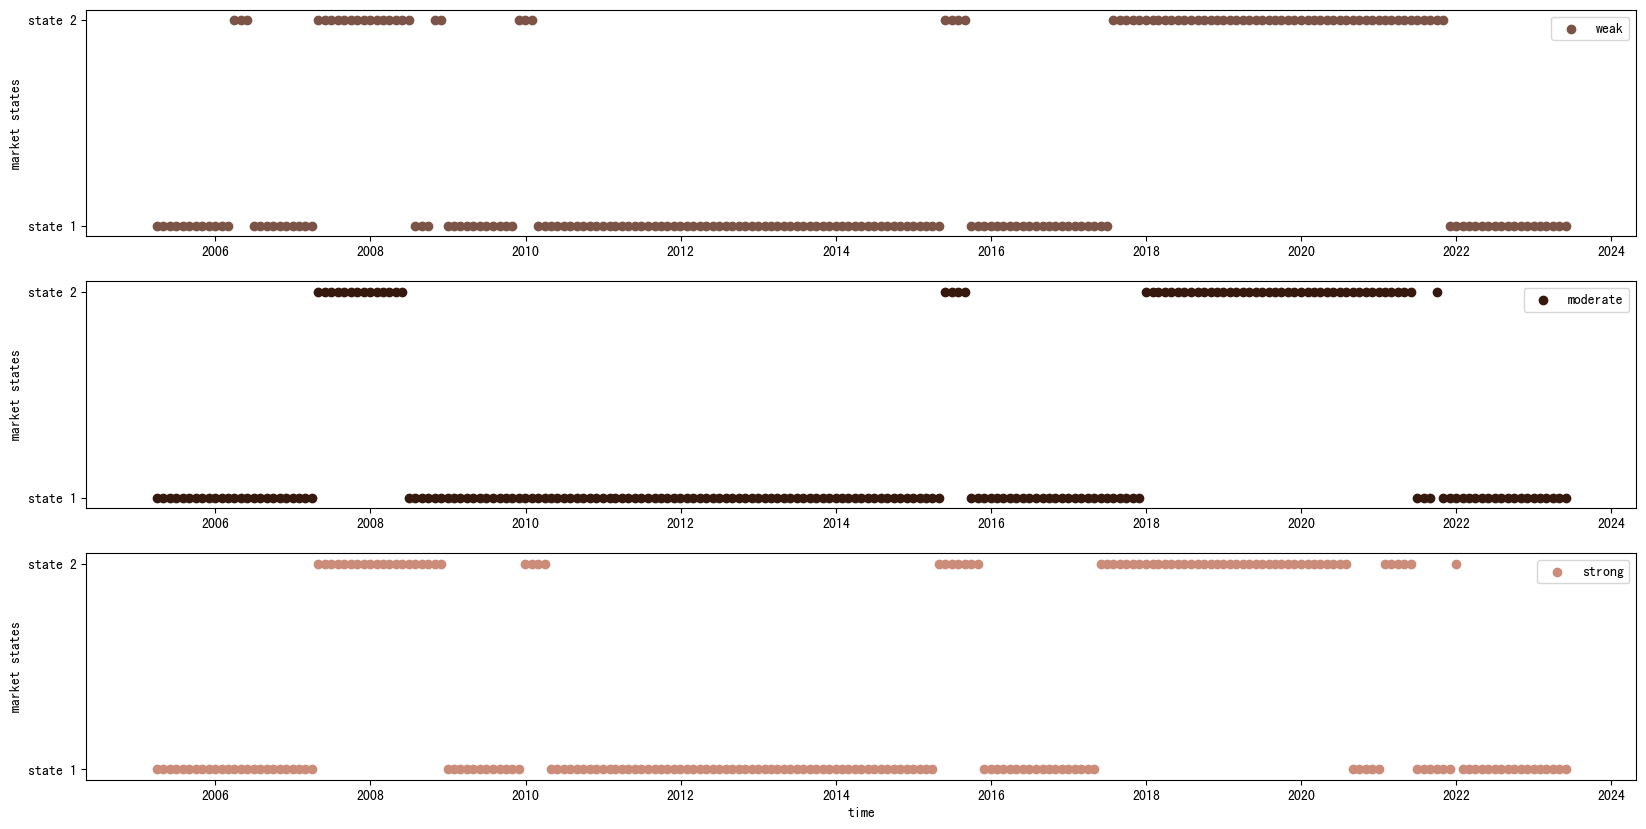

In [13]:
print("====================画状态图====================")
fig, ax = plt.subplots(5,1, figsize=(20,10), sharex=True)


for i,value in enumerate(['weak','neutral','strong']):
    plt.subplot(31*10+i+1)
    plt.scatter(states['datetime64'], states[value].map({1:'state 1', 2:'state 2'}), color=colors[value],label=labels[value])
    plt.legend()
    plt.ylabel('market states')
plt.xlabel('time')

In [14]:
def tokenize_and_del_stopword(stopword_set, text: pd.Series):
    raw_texts = text.to_list()
    res = []
    for raw_text in tqdm(raw_texts):
        tokenized_text = jieba.lcut_for_search(raw_text)
        temp = []
        for word in tokenized_text:
            if not word in stopword_set:
                temp.append(word)
        res.append(temp)
    return res

stopwords = []
with open("/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/baidu_stopwords.txt", "r") as f:
    for line in f.readlines():
        line = line.strip('\n')  # 去掉列表中每一个元素的换行符
        stopwords.append(line)
stopwords = set(stopwords)

Industry_policy = (
    pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/行业政策/ED_IndustryPolicy.csv')
    .pipe(lambda x: pd.merge(pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/RESSET_INDPOLICY_1.csv'), x, left_on='观测ID()_ID', right_on='ID'))
    .assign(InfoPublDateNP=lambda x: x[['InfoPublDate']].applymap(lambda x: np.datetime64(x)))
    .assign(TokenContent=lambda x: tokenize_and_del_stopword(stopwords, x['Content']))
    )

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(Industry_policy['TokenContent'])]
# model = Doc2Vec(documents, vector_size=10, window=4, min_count=1, workers=4)
fname = get_tmpfile("/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/my_doc2vec_model")
# model.save(fname)
model = Doc2Vec.load(fname)  # you can continue training with the loaded model!

# 计算每一个doc的向量
temp_doc = []
for doc in tqdm(Industry_policy['TokenContent'], desc='计算doc对应的向量'):
    temp_doc.append(model.infer_vector(doc))

Industry_policy = (
    Industry_policy
    .assign(DocVec = temp_doc)
    .assign(InfoPublYear = lambda x: x[['InfoPublDateNP']].applymap(lambda x: x.year))
    .assign(InfoPublMon = lambda x: x[['InfoPublDateNP']].applymap(lambda x: x.month))
    .assign(DocVec = temp_doc)
    .pipe(lambda x: x.loc[x['信息级别_InfoLevel']<=3])
    )
Industry_policy.head(1)

  0%|          | 0/22497 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
2024-05-20 22:50:35,998 : DEBUG : Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/jieba.cache
2024-05-20 22:50:36,344 : DEBUG : Dumping model to file cache /var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/jieba.cache
Loading model cost 0.376 seconds.
2024-05-20 22:50:36,375 : DEBUG : Loading model cost 0.376 seconds.
Prefix dict has been built successfully.
2024-05-20 22:50:36,376 : DEBUG : Prefix dict has been built successfully.
100%|██████████| 22497/22497 [00:40<00:00, 556.35it/s]
2024-05-20 22:51:16,628 : INFO : loading Doc2Vec object from /Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/my_doc2vec_model
2024-05-20 22:51:16,656 : INFO : loading dv recursively from /Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/my_doc2vec_model.dv.* with mmap=None
2024-05-

,观测ID()_ID,事件标志_EventFlg,信息发布日期_InfoPubDt,媒体出处代码()_MediaCd,媒体出处_Media,撰写机构_Writer,作者_Author,信息内容_Content,信息对象代码()_ObjCd,信息地域划分代码()_RegionCd,...,MediaCode,Writer,Author,InfoTitle,Content,InfoPublDateNP,TokenContent,DocVec,InfoPublYear,InfoPublMon
0,670676730611,1,2021-04-02,3,上海证券报,NaN,NaN,NaN,1000,142.0,...,3,NaN,NaN,权益变动信息 披露知多少,小费阿姨：小钟老师，近期我关注的上市公司发布了临时公告，是关于大股东持有公司权益变动...,2021-04-02,"[小费, 阿姨, 小钟, 老师, 近期, 关注, 上市, 公司, 上市公司, 发布, 临时,...","[1.8044181, -0.9940636, -0.9042743, 0.2622373,...",2021,4


# 验证识别结果合理性

## 状态转移时收益率方差是否产生变化

In [15]:
industry_return = (pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/行业月收益率_流通市值加权.csv',usecols=[0,1,2])
                   .assign(Date_np = lambda x: x[['日期_Date']].applymap(lambda x: np.datetime64(x)))
                   .assign(Year = lambda x: x[['Date_np']].applymap(lambda x: x.year))
                   .assign(Month = lambda x: x[['Date_np']].applymap(lambda x: x.month))
                  )
industry_return = industry_return.pivot(index=['Year','Month'],columns='证监会行业门类代码_Csrciccd1',values='行业月收益率_流通市值加权_Mrettmv').reset_index()
indret_and_states = pd.merge(industry_return, states, left_on=['Year','Month'], right_on=['Year','Month'])
data['monthly'] = indret_and_states
indret_and_states.head()

,Year,Month,A,B,C,D,E,F,G,H,...,N,O,P,Q,R,S,datetime64,weak,neutral,strong
0,2005,3,-0.1270,-0.0775,-0.1035,-0.0936,-0.1280,-0.0932,-0.0213,-0.0568,...,-0.0771,-0.2075,NaN,NaN,-0.1380,-0.1432,2005-03-31,1.0,1.0,1.0
1,2005,4,-0.0744,0.0072,-0.0448,-0.0106,-0.0383,-0.0189,0.0168,0.0455,...,0.0254,-0.0702,NaN,NaN,-0.2547,-0.0908,2005-04-30,1.0,1.0,1.0
2,2005,5,-0.0673,-0.1359,-0.0701,-0.0642,-0.0093,-0.0501,-0.1097,-0.0841,...,-0.0541,-0.0188,NaN,NaN,0.0376,-0.0265,2005-05-31,1.0,1.0,1.0
3,2005,6,0.0003,-0.0237,-0.0074,0.0481,0.0226,0.0246,0.0197,0.0061,...,0.0183,0.0173,NaN,NaN,0.0172,-0.0175,2005-06-30,1.0,1.0,1.0
4,2005,7,-0.0902,0.0307,-0.0386,-0.0029,-0.0635,-0.0315,0.0165,-0.0063,...,-0.0339,-0.1237,NaN,NaN,-0.1235,-0.0571,2005-07-31,1.0,1.0,1.0


====================展示有代表性的收益率散点图，示意分布存在差异====================


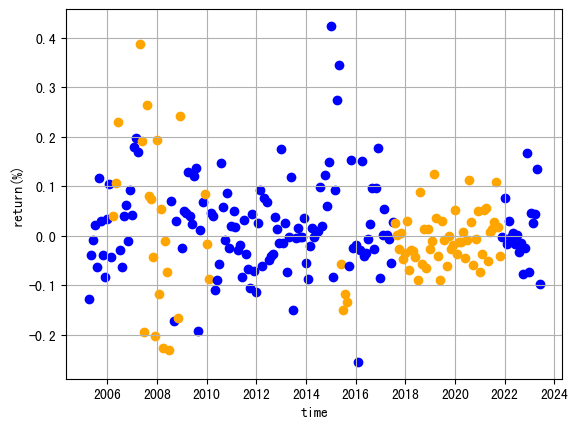

In [21]:
print("====================展示有代表性的收益率散点图，示意分布存在差异====================")
# ind = 'M'; state='strong'
# ind = 'M'; state='InfoLevel4'
# ind = 'N'; state='InfoLevel4'
ind = 'E'; state='weak'
fig, ax = plt.subplots()
colors = ['blue','orange']
for i in range(len(indret_and_states)):
    ax.scatter(indret_and_states['datetime64'][i], indret_and_states[ind][i], 
               color=colors[int(indret_and_states[state][i]-1)], 
               alpha=1)
# ax.set_title("不同市场状态下收益率散点图\n（行业={}, 信息级别={}）".format(ind, state[-1]))
ax.set_xlabel("time")
ax.set_ylabel('return(%)')
ax.grid(True)
plt.show()

In [135]:
print("====================不同状态行业收益率之间统计量的对比，说明收益率分布存在差异====================")
for state in ['weak','neutral','strong']:
    state_1 = []; state_2=[]
    for ind in industry_return.columns[2:]:
        state_1.append(indret_and_states.groupby(state)[ind].std().values[0])
        state_2.append(indret_and_states.groupby(state)[ind].std().values[1])
    print("state: {}".format(state))
    KS_result = ks_2samp(state_1, state_2)
    print("KS-stat={}{}".format(KS_result.statistic, pvalue2stars(KS_result.pvalue)))
    print("Mean of state 1={}, Mean of state 2={}".format(np.round(np.mean(state_1),4), np.round(np.mean(state_2),4)))
    print("Std of state 1={}, Std of state 2={},".format(np.round(np.std(state_1),4), np.round(np.std(state_2),4)))
    print("Min of state 1={}, Min of state 2={}".format(np.round(np.min(state_1),4), np.round(np.min(state_2),4)))
    print("25% of state 1={}, 25% of state 2={},".format(np.round(np.quantile(state_1, 0.25),4), np.round(np.quantile(state_2,0.25),4)))
    print("50% of state 1={}, 50% of state 2={},".format(np.round(np.quantile(state_1, 0.50),4), np.round(np.quantile(state_2,0.50),4)))
    print("75% of state 1={}, 75% of state 2={},".format(np.round(np.quantile(state_1, 0.75),4), np.round(np.quantile(state_2,0.75),4)))
    print("Max of state 1={}, Max of state 2={},".format(np.round(np.max(state_1),4), np.round(np.max(state_2),4)))
    print()

====================不同状态行业收益率之间统计量的对比，说明收益率分布存在差异====================
state: weak
KS-stat=0.5789473684210527***
Mean of state 1=0.0971, Mean of state 2=0.113
Std of state 1=0.0226, Std of state 2=0.0203,
Min of state 1=0.0762, Min of state 2=0.0872
25% of state 1=0.0833, 25% of state 2=0.1026,
50% of state 1=0.0903, 50% of state 2=0.1073,
75% of state 1=0.1007, 75% of state 2=0.1184,
Max of state 1=0.1711, Max of state 2=0.1843,

state: neutral
KS-stat=0.47368421052631576**
Mean of state 1=0.1005, Mean of state 2=0.1103
Std of state 1=0.0206, Std of state 2=0.0228,
Min of state 1=0.0805, Min of state 2=0.0801
25% of state 1=0.087, 25% of state 2=0.1,
50% of state 1=0.0956, 50% of state 2=0.1076,
75% of state 1=0.1048, 75% of state 2=0.1156,
Max of state 1=0.1666, Max of state 2=0.193,

state: strong
KS-stat=0.7368421052631579***
Mean of state 1=0.0941, Mean of state 2=0.118
Std of state 1=0.0219, Std of state 2=0.0223,
Min of state 1=0.0732, Min of state 2=0.0891
25% of state 1=0.082, 

====================基于事件研究法，展示状态转换时收益率标准差下降====================


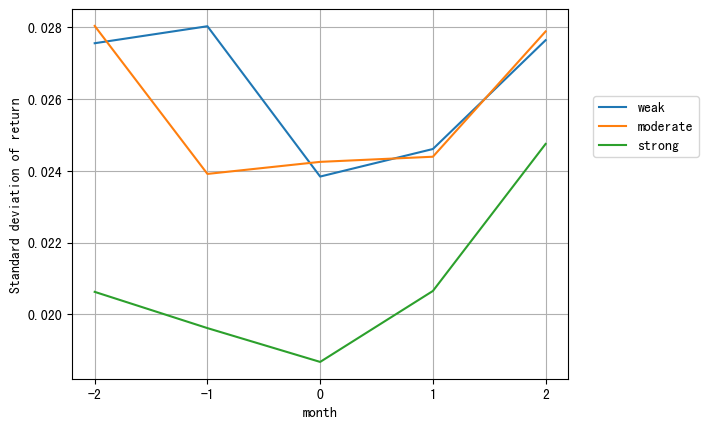

In [22]:
print("====================基于事件研究法，展示状态转换时收益率标准差下降====================")
temp = (pd.concat([pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/证监会门类行业日收益率/RESSET_DRET_INDUSTRY_1_1.csv'), 
                  pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/证监会门类行业日收益率/RESSET_DRET_INDUSTRY_1_2.csv')],
                  axis=0
                 )
        .assign(datetime64 = lambda x: x[['日期_Date']].applymap(lambda x: np.datetime64(x)))
        .set_index('datetime64')
        .pipe(lambda x: x.groupby('证监会行业门类代码_Csrciccd1')['行业日收益率_流通市值加权_Drettmv'].resample('M').std())
        .reset_index()
        .pivot_table(index='datetime64',columns='证监会行业门类代码_Csrciccd1',values='行业日收益率_流通市值加权_Drettmv')
       )
temp = pd.merge(indret_and_states, temp, left_on='datetime64',right_on='datetime64', suffixes=['','_Std'])
data['monthly'] = temp # GLOBAL VARIABLE
# display(temp.head())

var = temp[['datetime64','A_Std',
       'B_Std', 'C_Std', 'D_Std', 'E_Std', 'F_Std', 'G_Std', 'H_Std', 'I_Std',
       'J_Std', 'K_Std', 'L_Std', 'M_Std', 'N_Std', 'O_Std', 'P_Std', 'Q_Std',
       'R_Std', 'S_Std']]

fig, ax = plt.subplots()
n=2
for state in ['weak','neutral','strong']:
    diff = temp[[state]].diff()
    before_2=[];before_1=[]; current = []; after_1=[]; after_2=[]
    for i in (diff.loc[diff[state]!=0]).index:
        for ind in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S']:
            ind = ind + '_Std'
            current.append(temp[ind].iloc[i])
            if i-2 >= 0: before_2.append(temp[ind].iloc[i-2]) 
            if i-1 >= 0: before_1.append(temp[ind].iloc[i-1])
            if i+1 < len(temp): after_1.append(temp[ind].iloc[i+1])
            if i+2 < len(temp): after_2.append(temp[ind].iloc[i+2])
    y = [np.nanmean(before_2),np.nanmean(before_1), np.nanmean(current), np.nanmean(after_1), np.nanmean(after_2)]

    ax.plot([-2,-1,0,1,2],y,label=labels[state],)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=3, borderaxespad=0)
ax.set_ylabel('Standard deviation of return')
ax.set_xlabel('month')
ax.grid(True)
plt.show()

====================基于事件研究法，展示状态转换时政策文本的语意开始涣散====================


,Year,Month,A,B,C,D,E,F,G,H,...,K_Std,L_Std,M_Std,N_Std,O_Std,P_Std,Q_Std,R_Std,S_Std,concentration
0,2005,3,-0.1270,-0.0775,-0.1035,-0.0936,-0.1280,-0.0932,-0.0213,-0.0568,...,0.012501,0.010484,NaN,0.011397,0.023053,NaN,NaN,0.026498,0.013146,0.723126
1,2005,4,-0.0744,0.0072,-0.0448,-0.0106,-0.0383,-0.0189,0.0168,0.0455,...,0.016998,0.014878,NaN,0.013935,0.026680,NaN,NaN,0.034624,0.022022,0.728566
2,2005,5,-0.0673,-0.1359,-0.0701,-0.0642,-0.0093,-0.0501,-0.1097,-0.0841,...,0.017331,0.014268,NaN,0.009366,0.018780,NaN,NaN,0.023406,0.012944,0.755845
3,2005,6,0.0003,-0.0237,-0.0074,0.0481,0.0226,0.0246,0.0197,0.0061,...,0.023391,0.023798,NaN,0.021837,0.022973,NaN,NaN,0.031444,0.023701,0.770165
4,2005,7,-0.0902,0.0307,-0.0386,-0.0029,-0.0635,-0.0315,0.0165,-0.0063,...,0.021651,0.017073,NaN,0.017159,0.029239,NaN,NaN,0.038074,0.019766,0.793435


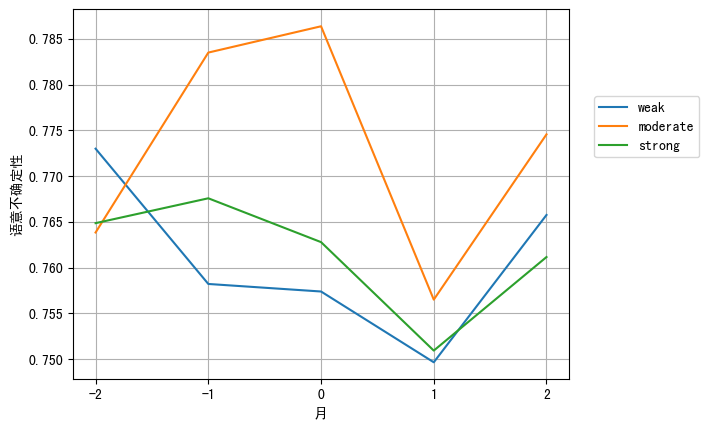

In [23]:
print("====================基于事件研究法，展示状态转换时政策文本的语意开始涣散====================")
policy_and_states = pd.merge(states, Industry_policy, left_on=['Year','Month'], right_on=['InfoPublYear','InfoPublMon'])
data['policy'] = policy_and_states

def recursive_corr(arr):
    corr_list = []
    for i in range(len(arr)):
        for j in range(i,len(arr)):
            corr_list.append(np.corrcoef(arr[i],arr[j]))
    return np.mean(corr_list)

temp = (pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].apply(lambda x: recursive_corr(x.values)))
        .rename(columns={'DocVec':'concentration'})
       )

temp = pd.merge(data['monthly'], temp, left_on='datetime64',right_on='datetime64')

data['monthly'] = temp

concentration = temp
display(temp.head())
fig, ax = plt.subplots()
for state in ['weak','neutral','strong']:
    diff = temp[[state]].diff()
    before_2=[];before_1=[]; current = []; after_1=[]; after_2=[]
    for i in (diff.loc[diff[state]!=0]).index:
            current.append(temp['concentration'].iloc[i])
            if i-2 >= 0: before_2.append(temp['concentration'].iloc[i-2]) 
            if i-1 >= 0: before_1.append(temp['concentration'].iloc[i-1])
            if i+1 < len(temp): after_1.append(temp['concentration'].iloc[i+1])
            if i+2 < len(temp): after_2.append(temp['concentration'].iloc[i+2])
    y = [np.nanmean(before_2),np.nanmean(before_1), np.nanmean(current), np.nanmean(after_1), np.nanmean(after_2)]
    ax.plot([-2,-1,0,1,2],y,label=labels[state],)
    
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=3, borderaxespad=0)
# ax.set_title('状态转换附近5月的政策语意相关性')
ax.set_xlabel('月')
ax.set_ylabel('语意不确定性')
ax.grid(True)
plt.show()

====================基于事件研究法，展示状态转换时政策文本数量增加====================


,Year,Month,A,B,C,D,E,F,G,H,...,O,P,Q,R,S,datetime64,weak,neutral,strong,concentration
0,2005,3,-0.1270,-0.0775,-0.1035,-0.0936,-0.1280,-0.0932,-0.0213,-0.0568,...,-0.2075,NaN,NaN,-0.1380,-0.1432,2005-03-31,1.0,1.0,1.0,106
1,2005,4,-0.0744,0.0072,-0.0448,-0.0106,-0.0383,-0.0189,0.0168,0.0455,...,-0.0702,NaN,NaN,-0.2547,-0.0908,2005-04-30,1.0,1.0,1.0,131
2,2005,5,-0.0673,-0.1359,-0.0701,-0.0642,-0.0093,-0.0501,-0.1097,-0.0841,...,-0.0188,NaN,NaN,0.0376,-0.0265,2005-05-31,1.0,1.0,1.0,106
3,2005,6,0.0003,-0.0237,-0.0074,0.0481,0.0226,0.0246,0.0197,0.0061,...,0.0173,NaN,NaN,0.0172,-0.0175,2005-06-30,1.0,1.0,1.0,75
4,2005,7,-0.0902,0.0307,-0.0386,-0.0029,-0.0635,-0.0315,0.0165,-0.0063,...,-0.1237,NaN,NaN,-0.1235,-0.0571,2005-07-31,1.0,1.0,1.0,89


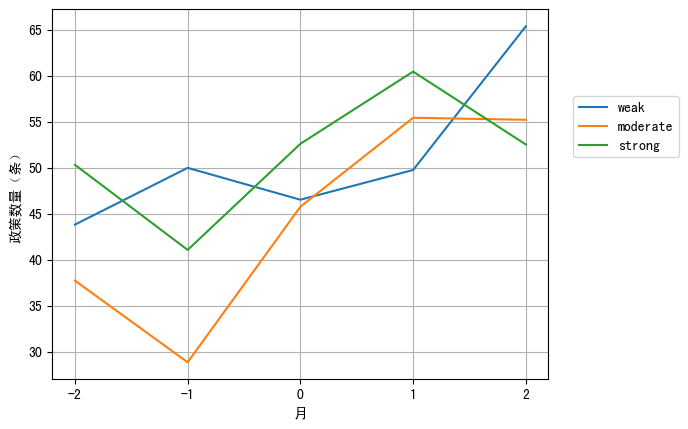

In [24]:
print("====================基于事件研究法，展示状态转换时政策文本数量增加====================")
temp = (pd.DataFrame(policy_and_states.groupby('datetime64')['DocVec'].count())
        .rename(columns={'DocVec':'concentration'})
       )

temp = pd.merge(indret_and_states, temp, left_on='datetime64',right_on='datetime64')
display(temp.head())

num = {}

fig, ax = plt.subplots()
for state in ['weak','neutral','strong']:
    diff = temp[[state]].diff()
    before_2=[];before_1=[]; current = []; after_1=[]; after_2=[]
    for i in (diff.loc[diff[state]!=0]).index:
            current.append(temp['concentration'].iloc[i])
            if i-2 >= 0: before_2.append(temp['concentration'].iloc[i-2]) 
            if i-1 >= 0: before_1.append(temp['concentration'].iloc[i-1])
            if i+1 < len(temp): after_1.append(temp['concentration'].iloc[i+1])
            if i+2 < len(temp): after_2.append(temp['concentration'].iloc[i+2])
    y = [np.nanmean(before_2),np.nanmean(before_1), np.nanmean(current), np.nanmean(after_1), np.nanmean(after_2)]
#     print(state, '\t', y)
#     if state=='general': print((diff.loc[diff[state]!=0]).index)
#     if state=='InfoLevel1': print((diff.loc[diff[state]!=0]).index)
    ax.plot([-2,-1,0,1,2],y,label=labels[state],)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=3, borderaxespad=0)
# ax.set_title('状态转换附近5月的政策数量')
ax.set_xlabel('月')
ax.set_ylabel('政策数量（条）')
ax.grid(True)
plt.show()

num = temp[['concentration','Year','Month']].rename(columns={'concentration':'num'})
data['monthly'] = pd.merge(data['monthly'], num, right_on=['Year','Month'], left_on=['Year','Month'])

In [25]:
ISI = (pd.read_csv('/Users/yanyan/Documents/MyQuant/研究——前景因子的构建/Data/ISI综合情绪指数表/QX_ISI.csv')
         .assign(datetimeNP=lambda x: x[['SgnMonth']].applymap(lambda x: np.datetime64(x)))
         .assign(Year = lambda x: x[['datetimeNP']].applymap(lambda y: y.year))
         .assign(Month = lambda x: x[['datetimeNP']].applymap(lambda y: y.month))
         .pipe(lambda x: pd.merge(x, states, right_on=['Year','Month'], left_on=['Year','Month']))
        )

# 000001指数
index_assetpricing = (pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/指数估值指标.csv',usecols=[0,1,2,3])
                      .assign(datetime64=lambda x: x[['交易日_TrdDt']].applymap(lambda x: np.datetime64(x)))
                      .assign(Year = lambda x: x[['datetime64']].applymap(lambda y: y.year))
                      .assign(Month = lambda x: x[['datetime64']].applymap(lambda y: y.month))
                      .assign(IndexCode=lambda x: x[['指数代码_IdxCd']].applymap(lambda y: str(y).zfill(6)))
                     )
index_000001 = index_assetpricing.loc[index_assetpricing['IndexCode']=='000001'][['Year','Month','滚动市盈率_PE_TTM','滚动股息率(%)_DYR_TTM']].groupby(['Year','Month']).mean()
index_000001.reset_index(inplace=True)

index_ret_000001 = (pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/指数收益率(000001).csv')
                      .assign(datetime64=lambda x: x[['交易日期_TrdDt']].applymap(lambda x: np.datetime64(x)))
                      .assign(Year = lambda x: x[['datetime64']].applymap(lambda y: y.year))
                      .assign(Month = lambda x: x[['datetime64']].applymap(lambda y: y.month))
                      .assign(IndexCode=lambda x: x[['指数代码_IdxCd']].applymap(lambda y: str(y).zfill(6)))
                      .pipe(lambda x: x[['Year','Month','收盘价(元/点)_ClPr']].groupby(['Year','Month']).apply(lambda x: x.iloc[-1]/x.iloc[0]-1)['收盘价(元/点)_ClPr'])
                      .pipe(lambda x: pd.DataFrame(x))
                      .rename(columns={'收盘价(元/点)_ClPr':'Return'})
#                       .assign(Return_next = lambda x: x['Return'].shift(-1))
#                       .dropna()
                   )

index_000001_ret_and_pricing = pd.merge(index_000001, index_ret_000001, left_on=['Year','Month'], right_index=True)
index_000001_ret_and_pricing = pd.merge(states, index_000001_ret_and_pricing, left_on=['Year','Month'], right_on=['Year','Month'])
index_000001_ret_and_pricing = (
    index_000001_ret_and_pricing
    .assign(weak = lambda x: x['weak']-1)
    .assign(neutral = lambda x: x['neutral']-1)
    .assign(strong = lambda x: x['strong']-1)
#     .assign(InfoLevel4 = lambda x: x['InfoLevel4']-1)
)
# index_000001_ret_and_pricing['all']=index_000001_ret_and_pricing['all']-1



riskfree_ret = (
    evaluator.Return[['月无风险收益率_Monrfret','datetime64']].drop_duplicates().ffill()
    .assign(Year = lambda x: x[['datetime64']].applymap(lambda y: y.year))
    .assign(Month = lambda x: x[['datetime64']].applymap(lambda y: y.month))
    .pipe(lambda x: x[['月无风险收益率_Monrfret','Year','Month']])
    .pipe(lambda x: x.groupby(['Year','Month'])['月无风险收益率_Monrfret'].last().reset_index())
)

index_000001_ret_and_pricing = (pd.merge(riskfree_ret, index_000001_ret_and_pricing, left_on=['Year','Month'], right_on=['Year','Month'])
                                .assign(Return = lambda x: x['Return']-x['月无风险收益率_Monrfret'])
                                .assign(Return_next = lambda x: x[['Return']].shift(-1))
                                .pipe(lambda x: x.loc[x['Return']!=x['Return_next']])
                                .dropna()
                               )

MacroIdx = (pd.read_csv('/Users/yanyan/Documents/MyQuant/研究——前景因子的构建/Data/宏观经济景气指数月度文件/CME_Mbcid3.csv')
         .assign(datetimeNP=lambda x: x[['Staper']].applymap(lambda x: np.datetime64(x)))
         .assign(Year = lambda x: x[['datetimeNP']].applymap(lambda y: y.year))
         .assign(Month = lambda x: x[['datetimeNP']].applymap(lambda y: y.month))
         .pipe(lambda x: pd.merge(x, states, right_on=['Year','Month'], left_on=['Year','Month']))
         .assign(Bcidm0302 = lambda x: zscore(x['Bcidm0302']))
        )

data['monthly'] = pd.merge(index_000001_ret_and_pricing[['Year','Month','滚动市盈率_PE_TTM','滚动股息率(%)_DYR_TTM','Return','Return_next']],
                              data['monthly'],
                              right_on=['Year','Month'], left_on=['Year','Month']
                          )
data['monthly'] = pd.merge(ISI[['Year','Month','StdExMacroISI']],
                              data['monthly'],
                              right_on=['Year','Month'], left_on=['Year','Month']
                          )

data['monthly'] = pd.merge(MacroIdx[['Bcidm0302','Year','Month']],
                              data['monthly'],
                              right_on=['Year','Month'], left_on=['Year','Month']
                          )

In [26]:
data['monthly'].columns

Index(['Bcidm0302', 'Year', 'Month', 'StdExMacroISI', '滚动市盈率_PE_TTM',
       '滚动股息率(%)_DYR_TTM', 'Return', 'Return_next', 'A', 'B', 'C', 'D', 'E',
       'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
       'datetime64', 'weak', 'neutral', 'strong', 'A_Std', 'B_Std', 'C_Std',
       'D_Std', 'E_Std', 'F_Std', 'G_Std', 'H_Std', 'I_Std', 'J_Std', 'K_Std',
       'L_Std', 'M_Std', 'N_Std', 'O_Std', 'P_Std', 'Q_Std', 'R_Std', 'S_Std',
       'concentration', 'num'],
      dtype='object')

In [27]:
# data['monthly'][['StdExMacroISI','weak']].plot(figsize=(20,5))

In [28]:
# temp = data['monthly'][['weak','neutral','strong','Return_next','Return','StdExMacroISI']]
# state = 'neutral' # 状态
# # for quzhi in [1,2]:
# t = temp.loc[temp[state]==quzhi]
# model = sm.OLS(
#     t['Return_next'],
#     sm.add_constant(pd.concat([
#         t['StdExMacroISI'],
#         t['StdExMacroISI']*(t[state]-1),
#         (t[state]-1)
#     ],axis=1))  
# ).fit() # cov_kwds={'maxlags':3}, cov_type='HAC'
# print(model.summary2())

# 市场状态的经济学含义，如何影响收益率

## 收益率分解视角

In [29]:
res={
    '$\alpha$':[],
    'alpha t-value':[],
    '$\beta$':[],
    'beta t-value':[],
    '$\gamma$':[],
    'gamma t-value':[],
    'const':[],
    'const_t-value':[],
    '$Adj.R^2$':[]
}
t = data['monthly']

for state in ['weak','neutral','strong']:
#     for quzhi in [0,1]:
    
    model = sm.OLS(t['Return_next'],
               sm.add_constant(pd.concat([
                   t[state]*t['滚动股息率(%)_DYR_TTM'],
                   t[['滚动股息率(%)_DYR_TTM']],
                   t[state]
               ],axis=1))
              ).fit()
#     print(model.summary2(),end='\n')
    res['$\alpha$'].append((model.params[0]*100).round(2))
    res['alpha t-value'].append("{}{}".format(model.tvalues[0].round(2), pvalue2stars(model.pvalues[0])))

    res['$\beta$'].append((model.params['滚动股息率(%)_DYR_TTM']*100).round(2))
    res['beta t-value'].append("{}{}".format(model.tvalues['滚动股息率(%)_DYR_TTM'].round(2), pvalue2stars(model.pvalues['滚动股息率(%)_DYR_TTM'])))
    
    res['$\gamma$'].append((model.params[state]*100).round(2))
    res['gamma t-value'].append("{}{}".format(model.tvalues[state].round(2), pvalue2stars(model.pvalues[state])))

    res['const'].append((model.params['const']*100).round(2))
    res['const_t-value'].append("{}{}".format(model.tvalues['const'].round(2), pvalue2stars(model.pvalues['const'])))
    
    res['$Adj.R^2$'].append((model.rsquared_adj*100).round(2))

print(pd.DataFrame(res, index=['weak','neutral','strong']).to_latex())

\begin{tabular}{lrlrlrlrlr}
\toprule
{} &  \$lpha\$ & alpha t-value &  \$eta\$ & beta t-value &  \$\textbackslash gamma\$ & gamma t-value &  const & const\_t-value &  \$Adj.R\textasciicircum 2\$ \\
\midrule
weak    &     1.93 &          1.45 &   -1.99 &        -1.13 &     -4.69 &         -1.7* &   5.47 &          1.39 &       0.45 \\
neutral &     1.41 &          1.01 &   -1.34 &        -0.75 &     -4.15 &         -1.47 &   4.67 &           1.2 &       0.37 \\
strong  &     1.88 &          1.36 &   -2.10 &        -1.17 &     -5.50 &       -1.99** &   6.98 &         1.76* &       1.56 \\
\bottomrule
\end{tabular}



/var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/ipykernel_11587/2058865581.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(res, index=['weak','neutral','strong']).to_latex())


In [30]:
res={
    '$\alpha$':[],
    'alpha t-value':[],
    '$\beta$':[],
    'beta t-value':[],
    '$\gamma$':[],
    'gamma t-value':[],
    'const':[],
    'const_t-value':[],
    '$Adj.R^2$':[]
}

for state in ['weak','neutral','strong']:
    model = sm.OLS(index_000001_ret_and_pricing['Return_next'],
               sm.add_constant(pd.concat([
                   (index_000001_ret_and_pricing[state])*index_000001_ret_and_pricing['滚动市盈率_PE_TTM'],
                   index_000001_ret_and_pricing[['滚动市盈率_PE_TTM']],
                   index_000001_ret_and_pricing[[state]]
               ],axis=1))
              ).fit()
    res['$\alpha$'].append((model.params[0]*100).round(2))
    res['alpha t-value'].append("{}{}".format(model.tvalues[0].round(2), pvalue2stars(model.pvalues[0])))

    res['$\beta$'].append((model.params['滚动市盈率_PE_TTM']*100).round(2))
    res['beta t-value'].append("{}{}".format(model.tvalues['滚动市盈率_PE_TTM'].round(2), pvalue2stars(model.pvalues['滚动市盈率_PE_TTM'])))
    
    res['$\gamma$'].append((model.params[state]*100).round(2))
    res['gamma t-value'].append("{}{}".format(model.tvalues[state].round(2), pvalue2stars(model.pvalues[state])))

    res['const'].append((model.params['const']*100).round(2))
    res['const_t-value'].append("{}{}".format(model.tvalues['const'].round(2), pvalue2stars(model.pvalues['const'])))
    
    res['$Adj.R^2$'].append((model.rsquared_adj*100).round(2))

print(pd.DataFrame(res, index=['weak','neutral','strong']).to_latex())

\begin{tabular}{lrlrlrlrlr}
\toprule
{} &  \$lpha\$ & alpha t-value &  \$eta\$ & beta t-value &  \$\textbackslash gamma\$ & gamma t-value &  const & const\_t-value &  \$Adj.R\textasciicircum 2\$ \\
\midrule
weak    &    -0.19 &         -1.62 &    0.17 &        1.77* &      2.04 &          0.86 &  -2.19 &          -1.3 &       0.76 \\
neutral &    -0.17 &         -1.47 &    0.15 &        1.68* &      1.20 &           0.5 &  -1.90 &         -1.18 &       1.11 \\
strong  &    -0.25 &       -2.12** &    0.22 &       2.33** &      2.04 &          0.87 &  -2.69 &         -1.63 &       3.21 \\
\bottomrule
\end{tabular}



/var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/ipykernel_11587/1935067906.py:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(res, index=['weak','neutral','strong']).to_latex())


## 不同区制、情绪对于EPU的影响

In [31]:
data['monthly'].columns

Index(['Bcidm0302', 'Year', 'Month', 'StdExMacroISI', '滚动市盈率_PE_TTM',
       '滚动股息率(%)_DYR_TTM', 'Return', 'Return_next', 'A', 'B', 'C', 'D', 'E',
       'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
       'datetime64', 'weak', 'neutral', 'strong', 'A_Std', 'B_Std', 'C_Std',
       'D_Std', 'E_Std', 'F_Std', 'G_Std', 'H_Std', 'I_Std', 'J_Std', 'K_Std',
       'L_Std', 'M_Std', 'N_Std', 'O_Std', 'P_Std', 'Q_Std', 'R_Std', 'S_Std',
       'concentration', 'num'],
      dtype='object')

In [32]:
daily_ret_000001 = (pd.read_csv('/Users/yanyan/Documents/MyQuant/MarketSeparationBasedOnNLP/Code（毕业论文）/Data/000001日收益率.csv')
                    .assign(datetimeNP = lambda x: x[['交易日期_TrdDt']].applymap(lambda j: np.datetime64(j)))
                     .assign(Year = lambda x: x[['datetimeNP']].applymap(lambda y: y.year))
                     .assign(Month = lambda x: x[['datetimeNP']].applymap(lambda y: y.month))
                   )
data['monthly'] = pd.merge(
    data['monthly'],
    daily_ret_000001.groupby(['Year','Month'])['涨跌幅(%)_ChgPct'].std().reset_index().rename(columns={'涨跌幅(%)_ChgPct':'000001波动率'}),
    left_on=['Year','Month'],
    right_on=['Year','Month']
)

In [33]:
EPU = (pd.read_excel('/Users/yanyan/Downloads/China_Mainland_Paper_EPU.xlsx',sheet_name='EPU 2000 onwards')
       .assign(Year=lambda x: x['year'])
       .assign(Month=lambda x: x['month'])
       .pipe(lambda x: x[['Year','Month','EPU']])
      )

data['monthly'] = pd.merge(
    data['monthly'],
    EPU,
    left_on=['Year','Month'],
    right_on=['Year','Month']
)

In [34]:
temp = data['monthly'] # [['EPU','StdExMacroISI','Bcidm0302','000001波动率']]
# temp = zscore(temp)
state = 'neutral' # 状态
# for quzhi in [1,2]:
# t = temp.loc[temp[state]==quzhi]

model = sm.OLS(
    temp['000001波动率'],
    sm.add_constant(pd.concat([
        temp[['EPU','StdExMacroISI','Bcidm0302']],
#         temp['EPU']*(temp[state]-1),
#         (temp[state]-1)
    ],axis=1))  
).fit() # cov_kwds={'maxlags':3}, cov_type='HAC'
print(model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.163   
Dependent Variable: 000001波动率        AIC:                423.1112
Date:               2024-05-20 23:01 BIC:                436.4805
No. Observations:   209              Log-Likelihood:     -207.56 
Df Model:           3                F-statistic:        14.55   
Df Residuals:       205              Prob (F-statistic): 1.26e-08
R-squared:          0.176            Scale:              0.43501 
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
const              1.7170   0.0788 21.7802 0.0000  1.5616  1.8724
EPU               -0.0022   0.0004 -5.6015 0.0000 -0.0030 -0.0014
StdExMacroISI      0.1278   0.0314  4.0648 0.0001  0.0658  0.1898
Bcidm0302         -0.0987   0.0458 -2.1560 0.0323 -0.1890 -0.0084
---------------------------

In [36]:
# temp[[state,'EPU', 'StdExMacroISI', 'Bcidm0302',ind]].query('weak==2')

# EPU对各个行业

In [37]:
print("==================输出结果==================")

res = {
    '行业':[],
    '政策情绪强度':[],
    '区制':[],
    'EPU':[],
#     'EPU t-value':[],
    'Adj. R^2':[]
}

temp = data['monthly'][['weak','neutral','strong','EPU', 'StdExMacroISI', 'Bcidm0302','A_Std',
       'B_Std', 'C_Std', 'D_Std', 'E_Std', 'F_Std', 'G_Std', 'H_Std', 'I_Std',
       'J_Std', 'K_Std', 'L_Std', 'M_Std', 'N_Std', 'O_Std', 'P_Std', 'Q_Std',
       'R_Std', 'S_Std']].copy()
temp[['EPU', 'StdExMacroISI', 'Bcidm0302']] = zscore(temp[['EPU', 'StdExMacroISI', 'Bcidm0302']])
# display(temp)

for ind in ['A_Std',
       'B_Std', 'C_Std', 'D_Std', 'E_Std', 'F_Std', 'G_Std', 'H_Std', 'I_Std',
       'J_Std', 'K_Std', 'L_Std', 'M_Std', 'N_Std', 'O_Std', 'P_Std', 'Q_Std',
       'R_Std', 'S_Std']:
    for state in ['strong']:
        reg_data = temp[[state,'EPU', 'StdExMacroISI', 'Bcidm0302',ind]].copy(deep=True)
        reg_data[[ind]] = reg_data[[ind]].shift(-1)
        for quzhi in [0,1,2]:
            if quzhi==0:
                detail_data = reg_data.copy(deep=True)
                detail_data.dropna(inplace=True)
            else:
                detail_data = reg_data.query("{}=={}".format(state,quzhi)).copy(deep=True)
                detail_data.dropna(inplace=True)
#             print(len(reg_data))            
            model = sm.OLS(
                detail_data[[ind]],
                sm.add_constant(
                    detail_data[['EPU','StdExMacroISI','Bcidm0302']]
                )
            ).fit()
            res['行业'].append(ind[0])
            res['政策情绪强度'].append(state)
            res['区制'].append('') if quzhi==0 else res['区制'].append(quzhi)
            res['EPU'].append("{}{}".format(np.round(model.params['EPU']*100,4),pvalue2stars(model.pvalues['EPU'])))
#             res['EPU t-value'].append(model.tvalues['EPU'])
            res['Adj. R^2'].append(model.rsquared_adj)

print(pd.DataFrame(res).to_latex())

==================输出结果==================
\begin{tabular}{lllllr}
\toprule
{} & 行业 &  政策情绪强度 & 区制 &         EPU &  Adj. R\textasciicircum 2 \\
\midrule
0  &  A &  strong &    &  -0.1895*** &  0.098476 \\
1  &  A &  strong &  1 &     -0.0902 &  0.010308 \\
2  &  A &  strong &  2 &  -0.4732*** &  0.205773 \\
3  &  B &  strong &    &  -0.3203*** &  0.185303 \\
4  &  B &  strong &  1 &   -0.224*** &  0.073469 \\
5  &  B &  strong &  2 &  -0.5499*** &  0.354157 \\
6  &  C &  strong &    &  -0.2837*** &  0.163955 \\
7  &  C &  strong &  1 &  -0.2063*** &  0.065973 \\
8  &  C &  strong &  2 &  -0.5376*** &  0.317039 \\
9  &  D &  strong &    &  -0.4118*** &  0.263582 \\
10 &  D &  strong &  1 &  -0.2312*** &  0.114188 \\
11 &  D &  strong &  2 &  -0.7119*** &  0.401399 \\
12 &  E &  strong &    &  -0.3559*** &  0.230489 \\
13 &  E &  strong &  1 &  -0.2908*** &  0.138573 \\
14 &  E &  strong &  2 &  -0.5723*** &  0.343145 \\
15 &  F &  strong &    &  -0.3476*** &  0.206641 \\
16 &  F &  strong

/var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/ipykernel_11587/501301925.py:47: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(res).to_latex())


2024-05-20 23:04:26,322 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-20 23:04:26,323 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-20 23:04:26,324 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-20 23:04:26,328 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-20 23:04:26,333 : INFO : Using categorical units to plot a list of strings that are all parsable as 

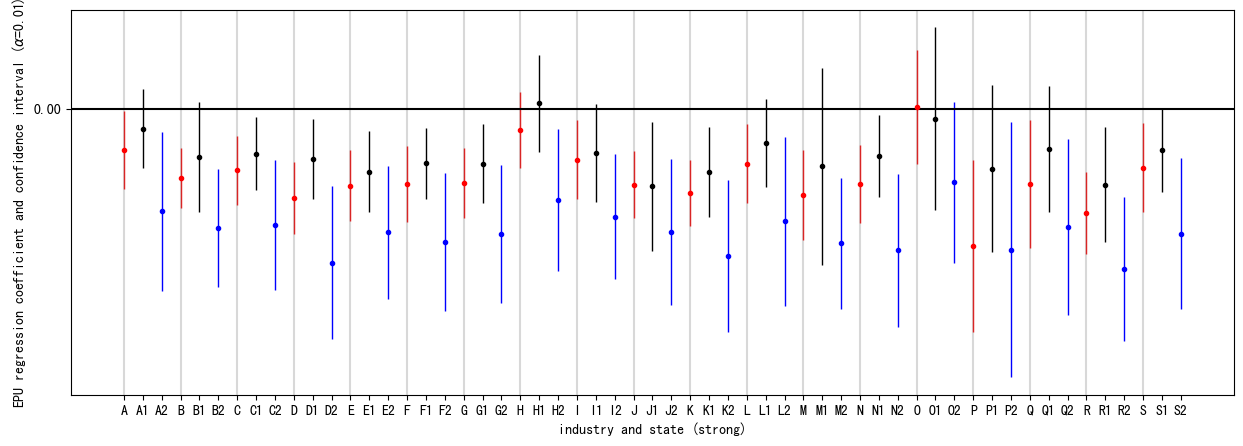

In [47]:
alpha=0.01

quzhi_color={0:'red', 1:'black', 2:'blue'}
def quzhi_name(ind:str, quzhi):
    if quzhi==0:
        return ind
    else:
        return ind + str(quzhi)

fig, ax = plt.subplots(figsize=(15,5))

temp = data['monthly'][['weak','neutral','strong','EPU', 'StdExMacroISI', 'Bcidm0302','A_Std',
       'B_Std', 'C_Std', 'D_Std', 'E_Std', 'F_Std', 'G_Std', 'H_Std', 'I_Std',
       'J_Std', 'K_Std', 'L_Std', 'M_Std', 'N_Std', 'O_Std', 'P_Std', 'Q_Std',
       'R_Std', 'S_Std']].copy()
temp[['EPU', 'StdExMacroISI', 'Bcidm0302']] = zscore(temp[['EPU', 'StdExMacroISI', 'Bcidm0302']])
# display(temp)

for ind in ['A_Std',
       'B_Std', 'C_Std', 'D_Std', 'E_Std', 'F_Std', 'G_Std', 'H_Std', 'I_Std',
       'J_Std', 'K_Std', 'L_Std', 'M_Std', 'N_Std', 'O_Std', 'P_Std', 'Q_Std',
       'R_Std', 'S_Std']:
    for state in ['strong']:
        reg_data = temp[[state,'EPU', 'StdExMacroISI', 'Bcidm0302',ind]].copy(deep=True)
        reg_data[[ind]] = reg_data[[ind]].shift(-1)
        for quzhi in [0,1,2]:
            if quzhi==0:
                detail_data = reg_data.copy(deep=True)
                detail_data.dropna(inplace=True)
            else:
                detail_data = reg_data.query("{}=={}".format(state,quzhi)).copy(deep=True)
                detail_data.dropna(inplace=True)
#             print(len(reg_data))            
            model = sm.OLS(
                detail_data[[ind]],
                sm.add_constant(
                    detail_data[['EPU','StdExMacroISI','Bcidm0302']]
                )
            ).fit(cov_type='HAC',cov_kwds={'maxlags':3})
            y_error = model.conf_int(alpha).loc['EPU',:].values.reshape((2,1))[1][0]\
                        - model.params['EPU']
            ax.errorbar(quzhi_name(ind[0],quzhi),
                        model.params['EPU'],
                        yerr=y_error,
                        fmt='o',
                        markersize=3,
                        color=quzhi_color[quzhi],
                        lw=1
                       )
            if quzhi==0:
                ax.axvline(quzhi_name(ind[0],quzhi),color='grey',alpha=0.3)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.set_xlabel('industry and state (strong)')
ax.set_ylabel(r'EPU regression coefficient and confidence interval ($\alpha$=0.01)')
# ax.set_title('收益率波动性对政策相关性回归结果\n '+r'$\alpha={}$'.format(alpha))
ax.axhline(0,color='black')
plt.show()

In [75]:
# A             & 农、林、牧、渔业                \\
B             & 采矿业                         \\
C             & 制造业                          \\
D             & 电力、热力、燃气及水生产和供应业                 \\
E             & 建筑业                            \\
F             & 批发和零售业                                              \\
G             & 交通运输、仓储和邮政业      \\
# H             & 住宿和餐饮业      \\
I             & 信息传输、软件和信息技术服务业  \\
J             & 金融业                                 \\
K             & 房地产业      \\
L             & 租赁和商务服务业      \\
M             & 科学研究和技术服务业      \\
N             & 水利、环境和公共设施管理业      \\
# O             & 	居民服务、修理和其他服务业      \\
# P             & 教育      \\
# Q             & 卫生和社会工作      \\
R             & 文化、体育和娱乐业      \\
S             & 综合     \\ \bottomrule

KeyError: "['EPU'] not in index"

<Axes: >

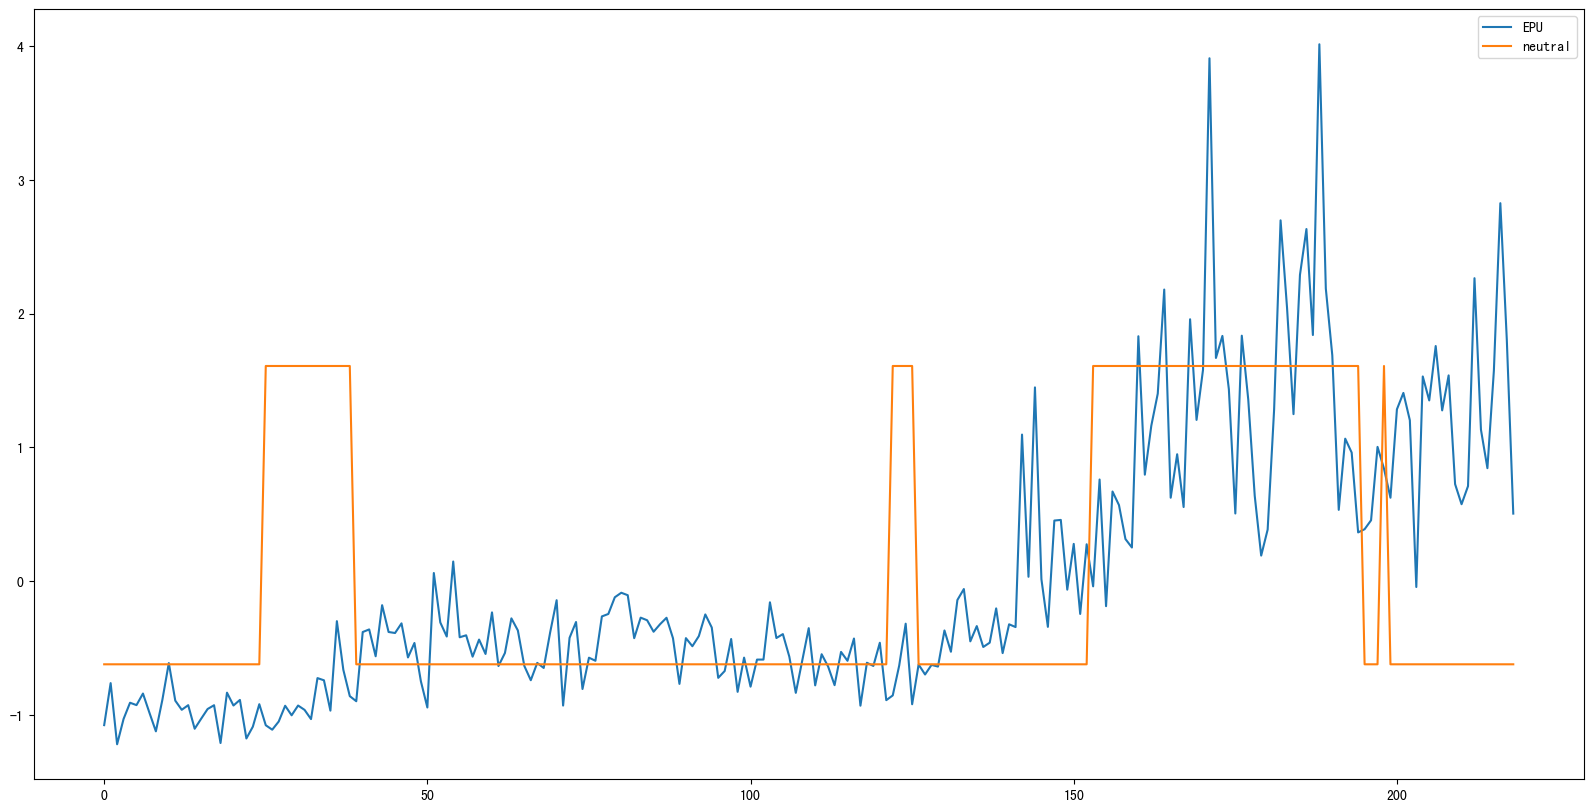

In [86]:
zscore(data['monthly'][['EPU','neutral']]).plot(figsize=(20,10))

# FF3

In [369]:
ff3_df = (pd.read_csv('/Users/yanyan/Downloads/MS_VAR评估结果_20240401.csv')
          .set_index('msg')
          .transpose()
          .reset_index()
          .iloc[1:,:]
          .assign(weight=lambda x: x[['index']].applymap(lambda j: j.split('_')[-2]))
          .pipe(lambda x: x.loc[x['index'].str.contains('总市值加权')])
          .pipe(lambda x: x.loc[x['weight']!='Monmc'])
          .assign(factor = lambda x: x[['index']].applymap(lambda j: j.split('_')[0]))
          .assign(industry = lambda x: x[['index']].applymap(lambda j: j.split('_')[-1]))
          .pipe(lambda x: x[['weak','neutral','strong','factor','industry']])
         )

print(len(ff3_df))
display(ff3_df.head())

57


msg,weak,neutral,strong,factor,industry
115,"(0.08047016274864376, 0.864872058168275)","(0.0689977173687487, 0.9724062204196311)","(0.08014354066985646, 0.8740170977101416)",市场溢酬因子,C
117,"(0.07839059674502713, 0.8838786577180184)","(0.07314795600747043, 0.954761073252185)","(0.097258005152742, 0.6888650154004499)",市场溢酬因子,K
119,"(0.08833634719710669, 0.7833149446078913)","(0.0728366881095663, 0.9562397735364707)","(0.13498343761501655, 0.29261315801762383)",市场溢酬因子,E
121,"(0.06781193490054249, 0.9575819968172047)","(0.14515459638929237, 0.27815541274899463)","(0.0673536989326463, 0.9623436237533456)",市场溢酬因子,S
123,"(0.05822784810126582, 0.9900886941705935)","(0.06941274123262088, 0.970970877056663)","(0.09063305115936694, 0.7659099077246887)",市场溢酬因子,I


In [370]:
def statPvalue2latex(tup:str):
    stat = float(tup.split(',')[0][1:])
    pvalue = float(tup.split(',')[1][:-1])
    
    stat = np.round(stat*100, 4)
    pvalue = np.round(pvalue,4)
    return "{}{} ({})".format(stat, pvalue2stars(pvalue), pvalue)

# statPvalue2latex('(0.1204606764888981, 0.4993795243229386)')

In [371]:
shichangyichou = (ff3_df.loc[ff3_df['factor']=='市场溢酬因子'].sort_values(by='industry')
                  .set_index('industry')
                  .assign(weak = lambda x: x[['weak']].applymap(statPvalue2latex))
                  .assign(neutral = lambda x: x[['neutral']].applymap(statPvalue2latex))
                  .assign(strong = lambda x: x[['strong']].applymap(statPvalue2latex))
                 )
zhangmianshizhibi = (ff3_df.loc[ff3_df['factor']=='账面市值比因子'].sort_values(by='industry')
                  .set_index('industry')
                  .assign(weak = lambda x: x[['weak']].applymap(statPvalue2latex))
                  .assign(neutral = lambda x: x[['neutral']].applymap(statPvalue2latex))
                  .assign(strong = lambda x: x[['strong']].applymap(statPvalue2latex))
                 )

shizhi = (ff3_df.loc[ff3_df['factor']=='市值因子'].sort_values(by='industry')
                  .set_index('industry')
                  .assign(weak = lambda x: x[['weak']].applymap(statPvalue2latex))
                  .assign(neutral = lambda x: x[['neutral']].applymap(statPvalue2latex))
                  .assign(strong = lambda x: x[['strong']].applymap(statPvalue2latex))
                 )

In [372]:
ff3_output = pd.concat([shichangyichou, zhangmianshizhibi, shizhi], axis=1)
display(ff3_output.sort_values(by='industry'))
print(ff3_output.sort_values(by='industry').to_latex())

msg,weak,neutral,strong,factor,weak,neutral,strong,factor,weak,neutral,strong,factor
industry,,,,,,,,,,,,
A,8.2098 (0.8491),10.4067 (0.6795),13.6456 (0.2803),市场溢酬因子,11.3834 (0.4848),14.4013 (0.2866),10.7656 (0.5655),账面市值比因子,15.1447 (0.1738),15.2314 (0.2296),14.0872 (0.2479),市值因子
B,9.792 (0.6711),11.2575 (0.5849),7.6831 (0.9022),市场溢酬因子,7.4774 (0.9136),11.0396 (0.6086),8.3364 (0.8435),账面市值比因子,10.5063 (0.5856),16.1029 (0.1789),10.3699 (0.6123),市值因子
C,8.047 (0.8649),6.8998 (0.9724),8.0144 (0.874),市场溢酬因子,12.4593 (0.3736),15.1484 (0.2347),8.9989 (0.7725),账面市值比因子,11.9982 (0.4197),13.8825 (0.327),6.7814 (0.9604),市值因子
D,12.2152 (0.3982),9.504 (0.7786),8.5664 (0.8202),市场溢酬因子,9.6022 (0.694),12.8761 (0.416),13.1855 (0.318),账面市值比因子,5.7324 (0.9916),9.7116 (0.7555),7.4899 (0.9172),市值因子
E,8.8336 (0.7833),7.2837 (0.9562),13.4983 (0.2926),市场溢酬因子,6.6727 (0.9631),12.43 (0.4598),7.9407 (0.8805),账面市值比因子,7.2785 (0.9282),6.8479 (0.9744),8.272 (0.8498),市值因子
F,9.0325 (0.7614),11.5792 (0.5487),7.5083 (0.9157),市场溢酬因子,10.2532 (0.6159),12.0668 (0.4971),7.3151 (0.9295),账面市值比因子,10.7233 (0.5608),14.0174 (0.3166),10.9036 (0.5497),市值因子
G,9.1591 (0.7463),9.9709 (0.7275),10.0202 (0.654),市场溢酬因子,12.7125 (0.3504),18.9147* (0.0734),8.1708 (0.8596),账面市值比因子,10.5335 (0.5827),11.4028 (0.5689),5.9717 (0.988),市值因子
H,13.4177 (0.2901),12.4922 (0.4539),11.5293 (0.4798),市场溢酬因子,10.6239 (0.5724),9.7012 (0.7569),15.5134 (0.1612),账面市值比因子,6.953 (0.9484),6.8686 (0.9736),6.5974 (0.9686),市值因子
I,5.8228 (0.9901),6.9413 (0.971),9.0633 (0.7659),市场溢酬因子,9.1501 (0.7474),8.8193 (0.8455),7.6831 (0.9022),账面市值比因子,9.6293 (0.6908),11.2368 (0.5864),9.2013 (0.75),市值因子


\begin{tabular}{lllllllllllll}
\toprule
msg &                weak &              neutral &            strong &  factor &                weak &             neutral &              strong &   factor &                weak &              neutral &              strong & factor \\
industry &                     &                      &                   &         &                     &                     &                     &          &                     &                      &                     &        \\
\midrule
A        &     8.2098 (0.8491) &     10.4067 (0.6795) &  13.6456 (0.2803) &  市场溢酬因子 &    11.3834 (0.4848) &    14.4013 (0.2866) &    10.7656 (0.5655) &  账面市值比因子 &    15.1447 (0.1738) &     15.2314 (0.2296) &    14.0872 (0.2479) &   市值因子 \\
B        &      9.792 (0.6711) &     11.2575 (0.5849) &   7.6831 (0.9022) &  市场溢酬因子 &     7.4774 (0.9136) &    11.0396 (0.6086) &     8.3364 (0.8435) &  账面市值比因子 &    10.5063 (0.5856) &     16.1029 (0.1789) &    10.3699 (0.6123) &   市值因子

/var/folders/7l/j9np0sbx1b33249mt44v25980000gn/T/ipykernel_89139/140003439.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ff3_output.sort_values(by='industry').to_latex())


In [ ]:
% Please add the following required packages to your document preamble:
% \usepackage{booktabs}
\begin{table}[]
\begin{tabular}{@{}lccccccccc@{}}
\toprule
   & \multicolumn{3}{c}{市场溢酬因子}                                                                                                                                                                                                                        & \multicolumn{3}{c}{账面市值比因子}                                                                                                                                                                                                                      & \multicolumn{3}{c}{市值因子}                                                                                                                                                                                                                          \\ \midrule
行业 & weak                                                                           & neutral                                                                         & strong                                                                         & weak                                                                           & neutral                                                                        & strong                                                                         & weak                                                                           & neutral                                                                         & strong                                                                         \\ \midrule
A  & \begin{tabular}[c]{@{}c@{}}7.6221\\ (0.9023)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}12.0461\\ (0.4994)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}12.9463\\ (0.3385)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}14.792\\ (0.1938)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}12.762\\ (0.427)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}14.9153\\ (0.1937)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}13.2278\\ (0.3054)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}13.2289\\ (0.3829)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}13.1487\\ (0.321)\end{tabular}                      \\
B  & \begin{tabular}[c]{@{}c@{}}10.0814\\ (0.6368)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}13.8514\\ (0.3296)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}8.8241\\ (0.7922)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}14.5298\\ (0.2099)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}12.0979\\ (0.4934)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}19.148**\\ (0.0444)\end{tabular}                    & \begin{tabular}[c]{@{}c@{}}11.3472\\ (0.4892)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}14.8579\\ (0.2541)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}15.2006\\ (0.1776)\end{tabular}                     \\
C  & \begin{tabular}[c]{@{}c@{}}8.5986\\ (0.8092)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}7.5327\\ (0.9433)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}5.6312\\ (0.9939)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}12.9747\\ (0.3267)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}8.8504\\ (0.8433)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}13.5996\\ (0.284)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}10.6329\\ (0.571)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}14.2249\\ (0.3)\end{tabular}                         & \begin{tabular}[c]{@{}c@{}}7.4255\\ (0.9217)\end{tabular}                      \\
D  & \begin{tabular}[c]{@{}c@{}}10.5967\\ (0.5752)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}14.6815\\ (0.2666)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}10.6275\\ (0.5824)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}10.2712\\ (0.6138)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}7.128\\ (0.9635)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}15.9735\\ (0.1391)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}10.5335\\ (0.5827)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}13.4468\\ (0.3642)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}8.0236\\ (0.8731)\end{tabular}                      \\
E  & \begin{tabular}[c]{@{}c@{}}10.3617\\ (0.6033)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}12.2951\\ (0.474)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}12.0997\\ (0.4199)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}11.2477\\ (0.5003)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}11.05\\ (0.6073)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}13.9584\\ (0.2573)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}9.2315\\ (0.7379)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}8.9853\\ (0.831)\end{tabular}                        & \begin{tabular}[c]{@{}c@{}}11.0784\\ (0.5299)\end{tabular}                     \\
F  & \begin{tabular}[c]{@{}c@{}}9.6835\\ (0.6849)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}9.5871\\ (0.7693)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}9.965\\ (0.6609)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}11.5461\\ (0.467)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}9.255\\ (0.8042)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}14.0136\\ (0.2528)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}10.8228\\ (0.5487)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}13.7892\\ (0.3352)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}8.5296\\ (0.8241)\end{tabular}                      \\
G  & \begin{tabular}[c]{@{}c@{}}7.0344\\ (0.9436)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}11.1226 \\ (0.5991)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}10.968\\ (0.542)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}6.1392\\ (0.9827)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}12.6479\\ (0.4382)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}11.0416\\ (0.5339)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}11.2477\\ (0.5003)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}15.2936\\ (0.2255)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}8.5204\\ (0.8252)\end{tabular}                      \\
H  & \begin{tabular}[c]{@{}c@{}}11.4376\\ (0.4796)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}12.5856\\ (0.4442)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}12.5966\\ (0.3714)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}6.7179\\ (0.9608)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}9.0164\\ (0.8276)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}10.83\\ (0.5586)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}9.9096\\ (0.6577)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}8.7674\\ (0.851)\end{tabular}                        & \begin{tabular}[c]{@{}c@{}}11.5753\\ (0.4746)\end{tabular}                     \\
I  & \begin{tabular}[c]{@{}c@{}}8.0922\\ (0.861)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}7.9062\\ (0.92)\end{tabular}                         & \begin{tabular}[c]{@{}c@{}}7.9039\\ (0.8842)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}14.8101\\ (0.1929)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}13.7269\\ (0.3401)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}15.7619\\ (0.149)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}9.2767\\ (0.7324)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}13.5817\\ (0.3523)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}8.7505\\ (0.8001)\end{tabular}                      \\
J  & \begin{tabular}[c]{@{}c@{}}17.2152*\\ (0.0867)\end{tabular}                    & \begin{tabular}[c]{@{}c@{}}13.7892\\ (0.3352)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}14.6577\\ (0.2098)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}11.2839\\ (0.4962)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}6.4329\\ (0.9859)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}13.2591\\ (0.3122)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}6.4105\\ (0.9739)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}7.5742\\ (0.9412)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}7.0758\\ (0.9446)\end{tabular}                      \\
\bottomrule
\end{tabular}
\end{table}

In [ ]:
% Please add the following required packages to your document preamble:
% \usepackage{booktabs}
\begin{table}[]
\begin{tabular}{@{}lccccccccc@{}}
\toprule
   & \multicolumn{3}{c}{市场溢酬因子}                                                                                                                                                                                                                        & \multicolumn{3}{c}{账面市值比因子}                                                                                                                                                                                                                      & \multicolumn{3}{c}{市值因子}                                                                                                                                                                                                                          \\ \midrule
行业 & weak                                                                           & neutral                                                                         & strong                                                                         & weak                                                                           & neutral                                                                        & strong                                                                         & weak                                                                           & neutral                                                                         & strong                                                                         \\ \midrule
J  & \begin{tabular}[c]{@{}c@{}}17.2152*\\ (0.0867)\end{tabular}                    & \begin{tabular}[c]{@{}c@{}}13.7892\\ (0.3352)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}14.6577\\ (0.2098)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}11.2839\\ (0.4962)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}6.4329\\ (0.9859)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}13.2591\\ (0.3122)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}6.4105\\ (0.9739)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}7.5742\\ (0.9412)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}7.0758\\ (0.9446)\end{tabular}                      \\
K  & \begin{tabular}[c]{@{}c@{}}7.7215\\ (0.8941)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}7.2733\\ (0.9568)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}10.6459\\ (0.5795)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}11.2477\\ (0.5003)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}8.5184\\ (0.873)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}12.4402\\ (0.3859)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}10.9855\\ (0.53)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}13.4987\\ (0.3598)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}8.6953\\ (0.8068)\end{tabular}                      \\
L  & \begin{tabular}[c]{@{}c@{}}12.1248\\ (0.4069)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}12.1291\\ (0.4905)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}14.4277\\ (0.224)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}12.1338\\ (0.4055)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}12.3262\\ (0.4702)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}16.8936\\ (0.1017)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}11.6637\\ (0.4551)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}12.9799\\ (0.4065)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}9.965\\ (0.6609)\end{tabular}                       \\
M  & \begin{tabular}[c]{@{}c@{}}6.7722\\ (0.9581)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}7.8751\\ (0.9224)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}6.2293\\ (0.9817)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}6.0307\\ (0.9855)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}10.1058\\ (0.7132)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}14.0136\\ (0.2528)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}11.9349\\ (0.4259)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}9.7116\\ (0.7555)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}11.8697\\ (0.4431)\end{tabular}                     \\
N  & \begin{tabular}[c]{@{}c@{}}11.302\\ (0.4942)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}8.3524\\ (0.8873)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}9.9282\\ (0.6653)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}8.2731\\ (0.843)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}7.2422\\ (0.9584)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}12.523\\ (0.378)\end{tabular}                       & \begin{tabular}[c]{@{}c@{}}12.7758\\ (0.3446)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}11.5792\\ (0.5487)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}11.6673\\ (0.4642)\end{tabular}                     \\
O  & \begin{tabular}[c]{@{}c@{}}25.4611***\\ (0.0022)\end{tabular}                  & \begin{tabular}[c]{@{}c@{}}29.695***\\ (0.0006)\end{tabular}                    & \begin{tabular}[c]{@{}c@{}}25.7177***\\ (0.0022)\end{tabular}                  & \begin{tabular}[c]{@{}c@{}}23.8065***\\ (0.0052)\end{tabular}                  & \begin{tabular}[c]{@{}c@{}}27.0492***\\ (0.0024)\end{tabular}                  & \begin{tabular}[c]{@{}c@{}}23.8682***\\ (0.0056)\end{tabular}                  & \begin{tabular}[c]{@{}c@{}}26.8897***\\ (0.001)\end{tabular}                   & \begin{tabular}[c]{@{}c@{}}31.4484***\\ (0.0002)\end{tabular}                   & \begin{tabular}[c]{@{}c@{}}23.0861***\\ (0.0081)\end{tabular}                  \\
P  & \begin{tabular}[c]{@{}c@{}}45.8228***\\ (0.0)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}47.0741***\\ (0.0)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}34.735***\\ (0.0)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}45.8228***\\ (0.0)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}47.0741***\\ (0.0)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}34.735***\\ (0.0)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}45.8228***\\ (0.0)\end{tabular}                     & \begin{tabular}[c]{@{}c@{}}47.8523***\\ (0.0)\end{tabular}                      & \begin{tabular}[c]{@{}c@{}}34.735***\\ (0.0)\end{tabular}                      \\
Q  & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}13.1284\\ (0.3139)\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}19.8589*\\ (0.0526)\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}11.5477\\ (0.4771)\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}11.0488\\ (0.5229)\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}17.8149\\ (0.1059)\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}12.3206\\ (0.3974)\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}15.9222\\ (0.1353)\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}23.8016**\\ (0.011)\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}11.2992\\ (0.5047)\end{tabular}} \\
R  & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}9.7107\\ (0.6811)\end{tabular}}  & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}11.7971\\ (0.5256)\end{tabular}}  & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}8.5664\\ (0.8202)\end{tabular}}  & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}8.8517\\ (0.781)\end{tabular}}   & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}9.9709\\ (0.7275)\end{tabular}}  & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}10.8852\\ (0.5517)\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}10.4159\\ (0.5965)\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}9.0371\\ (0.8253)\end{tabular}}   & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}9.4958\\ (0.7157)\end{tabular}}  \\
S  & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}8.2369\\ (0.8462)\end{tabular}}  & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}13.509\\ (0.3585)\end{tabular}}   & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}9.2841\\ (0.7405)\end{tabular}}  & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}11.1212\\ (0.5146)\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}11.2056\\ (0.5896)\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}11.2532\\ (0.5101)\end{tabular}} & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}7.7758\\ (0.8897)\end{tabular}}  & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}6.1112\\ (0.992)\end{tabular}}    & \multicolumn{1}{l}{\begin{tabular}[c]{@{}l@{}}5.8428\\ (0.9904)\end{tabular}}  \\ \bottomrule
\end{tabular}
\end{table}

<Axes: >

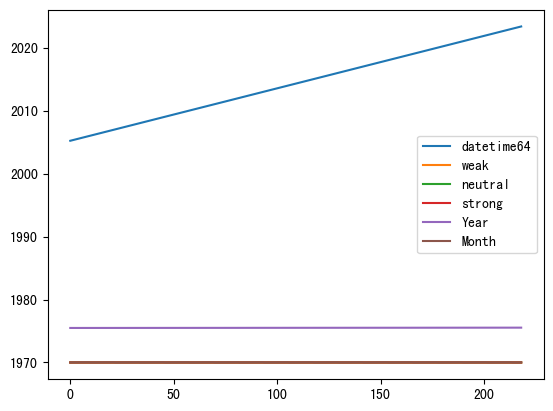

In [374]:
states.plot()

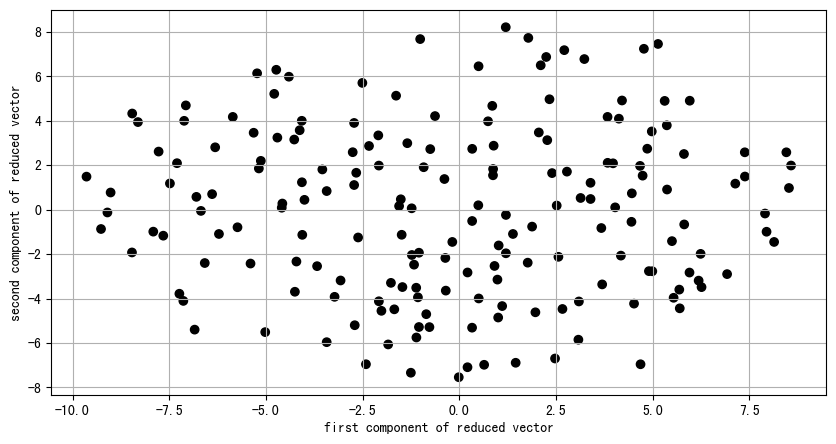

In [50]:
# 降维散点图
from sklearn.manifold import SpectralEmbedding, Isomap, MDS, TSNE

def scatter_dimension_reduced(start, end, state):
    temp = pd.merge(policy_and_states.groupby(['Year','Month'])['DocVec'].mean().reset_index(),
         states,
         left_on=['Year','Month'],
         right_on=['Year','Month']
        )
    temp = temp.loc[(temp['datetime64']>=start) & (temp['datetime64']<=end)]
#     display(temp)
    
    X_embedded = TSNE(n_components=2).fit_transform(np.array([i.tolist() for i in temp['DocVec'].values]))
    temp['TsneVec'] = [X_embedded[i] for i in range(len(X_embedded))]
    x = [i[0] for i in temp['TsneVec'].values]
    y = [i[1] for i in temp['TsneVec'].values]
    colors = temp[state].map({
        1:'#000000',
        2:'#000000'
    }).tolist()
    fig, ax = plt.subplots(figsize=(10,5))
    plt.scatter(x, y, c=colors)
    ax.set_xlabel('first component of reduced vector')
    ax.set_ylabel('second component of reduced vector')
#     ax.set_title('2维政策文本向量分布散点图')
    ax.grid(True)
    plt.show()

scatter_dimension_reduced(start='2007-12', end='2023-5',state='strong')